In [1]:
# load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
# CSV file is attached to our submission. Please change file path as needed
file_name = "/Users/johnwhendricks/Desktop/caravan/caravan-insurance-challenge.csv"
df = pd.read_csv(file_name)
df.head()

,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,train,33,1,3,2,8,0,5,1,3,...,0,0,0,1,0,0,0,0,0,0
1,train,37,1,2,2,8,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,0,4,2,4,...,0,0,0,1,0,0,0,0,0,0
3,train,9,1,3,3,3,2,3,2,4,...,0,0,0,1,0,0,0,0,0,0
4,train,40,1,4,2,10,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0


In [3]:
# data is clean
df.isnull().sum().sum() == 0 

True

In [4]:
# the following columns indicate number of policies in the given postal code
# we are going to create a new feature that sums up the different types of insurances bought at that postal code
columns_to_add = ['AWAPART',
'AWABEDR',
'AWALAND',
'APERSAUT',
'ABESAUT',
'AMOTSCO',
'AVRAAUT',
'AAANHANG',
'ATRACTOR',
'AWERKT',
'ABROM',
'ALEVEN',
'APERSONG',
'AGEZONG',
'AWAOREG',
'ABRAND',
'AZEILPL',
'APLEZIER',
'AFIETS',
'AINBOED',
'ABYSTAND']

In [5]:
# majority of values are either 0 or 1
for col in columns_to_add:
    print(df[col].value_counts())

0    5903
1    3909
2      10
Name: AWAPART, dtype: int64
0    9688
1     133
5       1
Name: AWABEDR, dtype: int64
0    9613
1     209
Name: AWALAND, dtype: int64
0     4825
1     4580
2      384
3       21
4        8
7        1
6        1
12       1
5        1
Name: APERSAUT, dtype: int64
0    9730
1      83
2       4
3       3
4       1
5       1
Name: ABESAUT, dtype: int64
0    9460
1     337
2      22
3       2
8       1
Name: AMOTSCO, dtype: int64
0    9808
1       9
2       3
3       1
4       1
Name: AVRAAUT, dtype: int64
0    9719
1      96
2       5
3       2
Name: AAANHANG, dtype: int64
0    9576
1     184
2      46
3       7
4       6
6       2
5       1
Name: ATRACTOR, dtype: int64
0    9790
1      21
2       7
3       2
6       1
4       1
Name: AWERKT, dtype: int64
0    9150
1     647
2      24
3       1
Name: ABROM, dtype: int64
0    9308
1     305
2     170
3      23
4      13
5       2
8       1
Name: ALEVEN, dtype: int64
0    9777
1      45
Name: APERSONG, dtype: int

In [6]:
# create code that indicates if the type of insurance was bought in that area or not
copy_df = df.copy()
for col in columns_to_add:
    copy_df[col] = copy_df[col].apply(lambda x : 1 if int(x) > 0 else 0)

In [7]:
# create new feature
df['num_policies'] = copy_df[columns_to_add].sum(axis=1)

In [8]:
df['num_policies'].value_counts()

1    4015
2    1970
3    1915
0    1079
4     647
5     148
6      34
7      11
8       3
Name: num_policies, dtype: int64

Text(0, 0.5, 'Frequency')

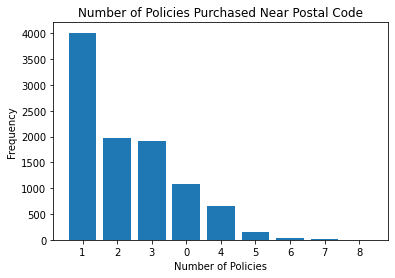

In [9]:
# graph new feature
vc = df['num_policies'].value_counts()
plt.bar([str(x) for x in vc.index],vc.values)
plt.title("Number of Policies Purchased Near Postal Code")
plt.xlabel("Number of Policies")
plt.ylabel("Frequency")

In [10]:
# from the data dictionary, the following columns are the only ones that are interges, the rest are categorical
number_cols = ['MAANTHUI','MGEMOMV','num_policies']

In [11]:
# the data dictionary suggests that all of these variables except ['MAANTHUI','MGEMOMV'] should be categorical
df.dtypes.value_counts()

int64     87
object     1
dtype: int64

In [12]:
# all of the columns that should be strings
str_cols = [col for col in df.columns if col not in number_cols and col !='ORIGIN' and col !='CARAVAN']

In [13]:
# make sure integers are acutally integers before converting them to strings
for col in str_cols:
    df[col].apply(int)

In [14]:
# convert categorical columns into strings
for col in str_cols:
    df[col] = df[col].apply(str)

In [15]:
# now all of our columns as strings except for the 3 columns with actual integers and the target variable
df.dtypes.value_counts()

object    84
int64      4
dtype: int64

Text(0, 0.5, 'Frequency')

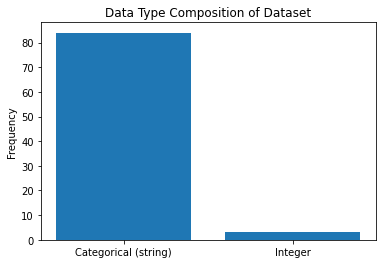

In [16]:
plt.bar(['Categorical (string)','Integer'],[84,3])
plt.title("Data Type Composition of Dataset")
plt.ylabel("Frequency")

In [17]:
# create correlation matrix
cm = df.corr()

Text(0.5, 1.0, 'Correlation Matrix Amongst Numerical Variables')

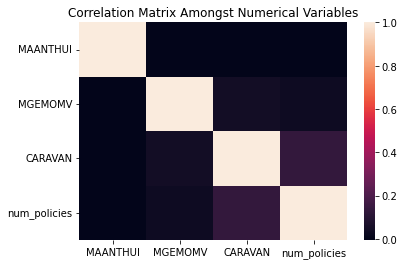

In [18]:
# the pandas corr() function only applies to numeric variables
# as a result, an incomplete heatmap is produced
# MAANTHUI and MGEMOMV show low correlation --> could remove these variables in future
ax = plt.axes()
sns.heatmap(cm,ax=ax)
ax.set_title("Correlation Matrix Amongst Numerical Variables")

In [19]:
df_cat = df[str_cols]

In [20]:
# we want to remove variables that are highly correlated, normally would measure with Pearson coefficient 
# use chi square test to find correlations because we are dealing with categorical variables
# the following chi square test code is from this medium article : https://medium.com/@ritesh.110587/correlation-between-categorical-variables-63f6bd9bf2f7
import scipy.stats as ss
from itertools import product

cat_var1 = tuple(str_cols)
cat_var2 = tuple(str_cols)

cat_var_prod = list(product(cat_var1,cat_var2, repeat = 1))

In [21]:
# code from the same article : https://medium.com/@ritesh.110587/correlation-between-categorical-variables-63f6bd9bf2f7
# this cell takes a long time to compute because it has to run the chi-square test thousands of times, once per potential combination
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(
                            df_cat[i[0]], df_cat[i[1]])))[1]))
result

[('MOSTYPE', 'MGEMLEEF', 0.0),
 ('MOSTYPE', 'MOSHOOFD', 0.0),
 ('MOSTYPE', 'MGODRK', 0.0),
 ('MOSTYPE', 'MGODPR', 0.0),
 ('MOSTYPE', 'MGODOV', 0.0),
 ('MOSTYPE', 'MGODGE', 0.0),
 ('MOSTYPE', 'MRELGE', 0.0),
 ('MOSTYPE', 'MRELSA', 0.0),
 ('MOSTYPE', 'MRELOV', 0.0),
 ('MOSTYPE', 'MFALLEEN', 0.0),
 ('MOSTYPE', 'MFGEKIND', 0.0),
 ('MOSTYPE', 'MFWEKIND', 0.0),
 ('MOSTYPE', 'MOPLHOOG', 0.0),
 ('MOSTYPE', 'MOPLMIDD', 0.0),
 ('MOSTYPE', 'MOPLLAAG', 0.0),
 ('MOSTYPE', 'MBERHOOG', 0.0),
 ('MOSTYPE', 'MBERZELF', 0.0),
 ('MOSTYPE', 'MBERBOER', 0.0),
 ('MOSTYPE', 'MBERMIDD', 0.0),
 ('MOSTYPE', 'MBERARBG', 0.0),
 ('MOSTYPE', 'MBERARBO', 0.0),
 ('MOSTYPE', 'MSKA', 0.0),
 ('MOSTYPE', 'MSKB1', 0.0),
 ('MOSTYPE', 'MSKB2', 0.0),
 ('MOSTYPE', 'MSKC', 0.0),
 ('MOSTYPE', 'MSKD', 0.0),
 ('MOSTYPE', 'MHHUUR', 0.0),
 ('MOSTYPE', 'MHKOOP', 0.0),
 ('MOSTYPE', 'MAUT1', 0.0),
 ('MOSTYPE', 'MAUT2', 0.0),
 ('MOSTYPE', 'MAUT0', 0.0),
 ('MOSTYPE', 'MZFONDS', 0.0),
 ('MOSTYPE', 'MZPART', 0.0),
 ('MOSTYPE', 'MINKM30', 0

In [22]:
# we divide 0.05 by the number of combinations tested. This is known as the Bernoulli method
# we do this because the probability of rejecting the null increases as you perform more and more tests
pairs_to_drop = list()
for i,j,k in result:
    if k < 0.05/len(result):
        pairs_to_drop.append((i,j))

In [23]:
# the combinations we are dropping (not dropping all of these columns though, just the ones necessary to get rid of the correlation)
len(pairs_to_drop)

2624

In [24]:
# make new list to_drop, which contains all the columns to be removed
to_drop = list()
for i,_ in pairs_to_drop:
    for tup in pairs_to_drop:
        if i in tup[0] or i in tup[1]:
            pairs_to_drop.remove(tup)
            if i not in to_drop:
                to_drop.append(i)


In [25]:
# number of columns we are dropping
len(to_drop)

68

In [26]:
new_df = df.drop(columns=to_drop)

In [27]:
# we learned to remove columns of low-variance from the following source : https://www.kaggle.com/code/lmorgan95/islr-tree-based-methods-ch-8-solutions
threshold=0.99
to_drop_2 = list()
for col in new_df.columns:
    print(col)
    val_counts = new_df[col].value_counts() / new_df[col].value_counts().sum()
    print(val_counts)
    print("***************")
    for i in val_counts.values:
        if i > threshold and col !='CARAVAN':
            to_drop_2.append(col)

ORIGIN
train    0.592751
test     0.407249
Name: ORIGIN, dtype: float64
***************
MAANTHUI
1     0.907656
2     0.083588
3     0.006516
7     0.000814
4     0.000407
5     0.000305
6     0.000305
10    0.000204
8     0.000204
Name: MAANTHUI, dtype: float64
***************
MGEMOMV
3    0.459479
2    0.368153
4    0.115251
1    0.046019
5    0.010792
6    0.000305
Name: MGEMOMV, dtype: float64
***************
MINK3045
4    0.224700
3    0.202505
5    0.161372
2    0.159743
0    0.079617
6    0.068316
1    0.049481
7    0.034311
9    0.013643
8    0.006312
Name: MINK3045, dtype: float64
***************
MINK7512
0    0.556302
1    0.229179
2    0.127876
3    0.043677
4    0.028304
5    0.012116
6    0.001018
8    0.000713
9    0.000611
7    0.000204
Name: MINK7512, dtype: float64
***************
MINK123M
0    0.840257
1    0.129200
2    0.019141
3    0.006720
4    0.003869
5    0.000407
6    0.000204
9    0.000102
7    0.000102
Name: MINK123M, dtype: float64
***************
PZEILPL
0

In [28]:
# drop columns with low variance
newer_df = new_df.drop(columns=to_drop_2) 

In [29]:
newer_df

,ORIGIN,MAANTHUI,MGEMOMV,MINK3045,MINK7512,MINK123M,PFIETS,APERSAUT,AMOTSCO,ATRACTOR,ALEVEN,ABRAND,AFIETS,CARAVAN,num_policies
0,train,1,3,4,0,0,0,1,0,0,0,1,0,0,2
1,train,1,2,0,2,0,0,0,0,0,0,1,0,0,2
2,train,1,2,5,0,0,0,1,0,0,0,1,0,0,3
3,train,1,3,5,0,0,0,1,0,0,0,1,0,0,2
4,train,1,4,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9817,test,1,2,6,0,0,0,1,0,0,0,1,0,0,3
9818,test,1,2,3,2,0,0,1,0,0,1,1,0,1,3
9819,test,1,2,5,0,0,0,1,0,0,0,1,0,0,3
9820,test,1,3,4,1,0,0,1,0,0,0,0,0,0,1


In [30]:
# split data into training and testing
train = newer_df[newer_df['ORIGIN']=='train']
train.drop(columns='ORIGIN', inplace=True)

x = train.drop(columns='CARAVAN')
y = train['CARAVAN']

x, y = SMOTE().fit_resample(x,y)

train_resampled = x
train_resampled['CARAVAN'] = y

test = newer_df[newer_df['ORIGIN']=='test']
test.drop(columns='ORIGIN', inplace=True)

/var/folders/sx/dymxkj2j1636xvkc7jyhyp840000gn/T/ipykernel_2146/1478001556.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns='ORIGIN', inplace=True)
/var/folders/sx/dymxkj2j1636xvkc7jyhyp840000gn/T/ipykernel_2146/1478001556.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns='ORIGIN', inplace=True)


In [31]:
# this is the class imbalance before using SMOTE
train['CARAVAN'].value_counts()

0    5474
1     348
Name: CARAVAN, dtype: int64

Text(0.5, 1.0, 'Class Imbalance Before SMOTE')

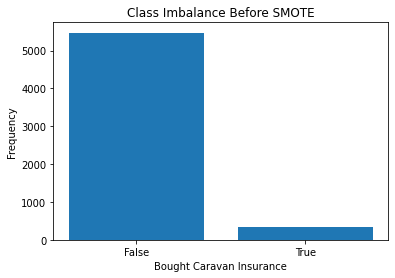

In [32]:
vc_before = train['CARAVAN'].apply(lambda x : "True" if x==1 else "False").value_counts()
plt.bar(vc_before.index,vc_before.values)
plt.ylabel("Frequency")
plt.xlabel("Bought Caravan Insurance")
plt.title("Class Imbalance Before SMOTE")

Text(0.5, 1.0, 'Class Imbalance After SMOTE')

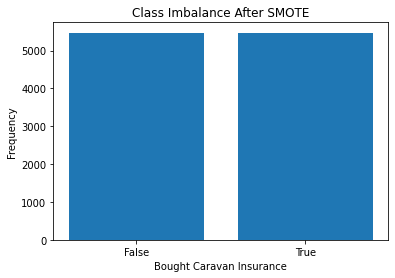

In [33]:
# with SMOTE, our data is now balanced
vc_after = train_resampled['CARAVAN'].apply(lambda x : "True" if x==1 else "False").value_counts()
plt.bar(vc_after.index,vc_after.values)
plt.ylabel("Frequency")
plt.xlabel("Bought Caravan Insurance")
plt.title("Class Imbalance After SMOTE")

In [34]:
X_train = train_resampled.drop(columns='CARAVAN')
y_train = train_resampled['CARAVAN']

X_test = test.drop(columns='CARAVAN')
y_test = test['CARAVAN']

In [35]:
'''translation : Number of houses 1 - 10, Avg size household 1 - 6, Income 30-45,000, Income 75-122, 000,
Income >123,000, Contribution bicycle policies, number of car policies, Number of motorcycle/scooter policies,
Number of tractor policies, Number of life insurances, Number of fire policies, Number of bicycle policies
'''
X_train.columns

Index(['MAANTHUI', 'MGEMOMV', 'MINK3045', 'MINK7512', 'MINK123M', 'PFIETS',
       'APERSAUT', 'AMOTSCO', 'ATRACTOR', 'ALEVEN', 'ABRAND', 'AFIETS',
       'num_policies'],
      dtype='object')

In [36]:
X_train.dtypes

MAANTHUI         int64
MGEMOMV          int64
MINK3045        object
MINK7512        object
MINK123M        object
PFIETS          object
APERSAUT        object
AMOTSCO         object
ATRACTOR        object
ALEVEN          object
ABRAND          object
AFIETS          object
num_policies     int64
dtype: object

In [37]:
str_cols = [x for x in X_train.columns if x not in number_cols]

In [38]:
# encode categorical variables with one-hot encoding

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder().fit(X_train[str_cols])

encoded = pd.DataFrame(enc.transform(X_train[str_cols]).toarray())

enc_ = OneHotEncoder().fit(X_test[str_cols])

encoded_ = pd.DataFrame(enc_.transform(X_test[str_cols]).toarray())

In [39]:
# sparse matrix --> use truncated Singular Value Decomposition (SVD)
encoded

,0,1,2,3,4,5,6,7,8,9,...,6187,6188,6189,6190,6191,6192,6193,6194,6195,6196
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
encoded.rename(str,axis='columns',inplace=True)
encoded_.rename(str,axis='columns',inplace=True)

In [41]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler().fit(X_train[number_cols])
scaled = scale.transform(X_train[number_cols])

scale_ = StandardScaler().fit(X_test[number_cols])
scaled_ = scale_.transform(X_test[number_cols])

In [42]:
def train_test(n_components):
    
    '''
    tests different number of components for SVD;
    then tests various models 
    '''
    
    model = TruncatedSVD(n_components=n_components)
    model.fit(encoded) 
    transformed = model.transform(encoded)

    model_ = TruncatedSVD(n_components=n_components)
    model_.fit(encoded_) 
    transformed_ = model_.transform(encoded_)
    
    transformed = pd.merge(pd.DataFrame(transformed, columns= [str(x) for x in range(transformed.shape[1])]), pd.DataFrame(scaled, columns=number_cols), left_index=True, right_index=True)
    transformed_ = pd.merge(pd.DataFrame(transformed_, columns=[str(x) for x in range(transformed_.shape[1])]), pd.DataFrame(scaled_, columns=number_cols), left_index=True, right_index=True)
    
    print("-------------------------")
    print(n_components)
    
    lr = LogisticRegression().fit(transformed, y_train)
    y_pred = lr.predict(transformed_)
    print(classification_report(y_test, y_pred))
    
    rf = RandomForestClassifier().fit(transformed, y_train)
    y_pred = rf.predict(transformed_)
    print(classification_report(y_test, y_pred))
    
    nb = GaussianNB().fit(transformed, y_train)
    y_pred = nb.predict(transformed_)
    print(classification_report(y_test, y_pred))
    
    ab = AdaBoostClassifier().fit(transformed, y_train)
    y_pred = ab.predict(transformed_)
    print(classification_report(y_test, y_pred))
    
    xg = XGBClassifier().fit(transformed, y_train)
    y_pred = xg.predict(transformed_)
    print(classification_report(y_test, y_pred))

In [43]:
# from trial and error, 2 to 4 components works best for SVD
for i in range(2,5):
    train_test(n_components=i)

-------------------------
2
              precision    recall  f1-score   support

           0       0.96      0.57      0.72      3762
           1       0.08      0.60      0.14       238

    accuracy                           0.57      4000
   macro avg       0.52      0.58      0.43      4000
weighted avg       0.91      0.57      0.68      4000

              precision    recall  f1-score   support

           0       0.94      0.87      0.91      3762
           1       0.09      0.19      0.12       238

    accuracy                           0.83      4000
   macro avg       0.51      0.53      0.51      4000
weighted avg       0.89      0.83      0.86      4000

              precision    recall  f1-score   support

           0       0.95      0.34      0.50      3762
           1       0.06      0.73      0.12       238

    accuracy                           0.36      4000
   macro avg       0.51      0.53      0.31      4000
weighted avg       0.90      0.36      0.48   

In [44]:
# we will reduce data to 2 components
svd = TruncatedSVD(n_components=2)
svd.fit(encoded) 
transformed = svd.transform(encoded)

svd_ = TruncatedSVD(n_components=2)
svd_.fit(encoded_) 
transformed_ = svd_.transform(encoded_)

In [45]:
transformed = pd.merge(pd.DataFrame(transformed, columns= [str(x) for x in range(transformed.shape[1])]), pd.DataFrame(scaled, columns=number_cols), left_index=True, right_index=True)
transformed_ = pd.merge(pd.DataFrame(transformed_, columns=[str(x) for x in range(transformed_.shape[1])]), pd.DataFrame(scaled_, columns=number_cols), left_index=True, right_index=True)

In [46]:
# below are the various metrics we can use to test cross-validation. We will be using f1_weighted
import sklearn

sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [47]:
# 5 folds is generally a good number
cv = 5

log_reg = LogisticRegression()
score_lin_reg = cross_val_score(log_reg,transformed,y_train, cv=cv, scoring='f1_weighted')
print(sum(score_lin_reg)/cv)

rf = RandomForestClassifier().fit(transformed, y_train)
score_rf = cross_val_score(rf,transformed,y_train, cv=cv, scoring='f1_weighted')
print(sum(score_rf)/cv)
    
nb = GaussianNB().fit(transformed, y_train)
score_nb = cross_val_score(nb,transformed,y_train, cv=cv, scoring='f1_weighted')
print(sum(score_nb)/cv)
    
ab = AdaBoostClassifier().fit(transformed, y_train)
score_ab = cross_val_score(ab,transformed,y_train, cv=cv, scoring='f1_weighted')
print(sum(score_ab)/cv)
    
xg = XGBClassifier().fit(transformed, y_train)
score_xg = cross_val_score(xg,transformed,y_train, cv=cv, scoring='f1_weighted')
print(sum(score_xg)/cv)

0.6607339694281216
0.8885526224097061
0.6064065690573901
0.7437634441742444
0.8855158430516206


In [48]:
# random forest performs the best, now let's test it on the test data

rf = RandomForestClassifier().fit(transformed, y_train)
y_pred = rf.predict(transformed_)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.86      0.90      3762
           1       0.10      0.23      0.14       238

    accuracy                           0.82      4000
   macro avg       0.52      0.55      0.52      4000
weighted avg       0.90      0.82      0.86      4000



In [49]:
# now let's do some hyperparameter tuning to maximize our f1-score for positive predictions (1=Bought Caravan Insurance, 0=Did not buy Caravan Insurance)
best_f1 = {}
for max_depth in range(2,12):
    for min_samples_split in range(2,5):
        rf = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split).fit(transformed, y_train)
        y_pred = rf.predict(transformed_)
        print(f"Random Forest with max_depth of {max_depth} and min_samples_split of {min_samples_split}")
        print(classification_report(y_test, y_pred))
        print("*********************")

Random Forest with max_depth of 2 and min_samples_split of 2
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      3762
           1       0.11      0.55      0.19       238

    accuracy                           0.72      4000
   macro avg       0.54      0.64      0.51      4000
weighted avg       0.91      0.72      0.79      4000

*********************
Random Forest with max_depth of 2 and min_samples_split of 3
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      3762
           1       0.11      0.58      0.19       238

    accuracy                           0.71      4000
   macro avg       0.54      0.64      0.50      4000
weighted avg       0.91      0.71      0.78      4000

*********************
Random Forest with max_depth of 2 and min_samples_split of 4
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      3762
          

Random Forest with max_depth of 8 and min_samples_split of 4
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      3762
           1       0.09      0.43      0.15       238

    accuracy                           0.70      4000
   macro avg       0.52      0.58      0.48      4000
weighted avg       0.90      0.70      0.78      4000

*********************
Random Forest with max_depth of 9 and min_samples_split of 2
              precision    recall  f1-score   support

           0       0.95      0.76      0.85      3762
           1       0.09      0.37      0.14       238

    accuracy                           0.74      4000
   macro avg       0.52      0.57      0.50      4000
weighted avg       0.90      0.74      0.80      4000

*********************
Random Forest with max_depth of 9 and min_samples_split of 3
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      3762
          

In [50]:
# final model
rf = RandomForestClassifier(max_depth=3, min_samples_split=2).fit(transformed, y_train)
y_pred = rf.predict(transformed_)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83      3762
           1       0.11      0.54      0.19       238

    accuracy                           0.72      4000
   macro avg       0.54      0.64      0.51      4000
weighted avg       0.91      0.72      0.79      4000



In [54]:
# code from https://www.programiz.com/python-programming/writing-csv-files#google_vignette
import csv
with open('predictions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for pred in y_pred:
        writer.writerow([pred])

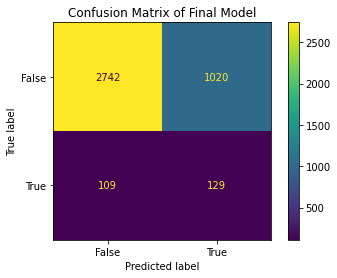

In [52]:
'''
The confusion matrix shows that our model predicted many false positives (upper-right quadrant).
At the same time, our model deteced the majority of those who did buy caravan insurance (149 vs 89).
In marketing, it is ok to have several false positives if it means that the target population is 
reached. Therefore, the model is overall successful, though needs refinement. 
'''
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=[False,True])

cm_display.plot()
plt.title("Confusion Matrix of Final Model")
plt.show()

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Component1'),
  Text(1, 0, 'Component2'),
  Text(2, 0, 'Number of Houses'),
  Text(3, 0, 'Avg Size Household'),
  Text(4, 0, 'Number of Insurance Polices')])

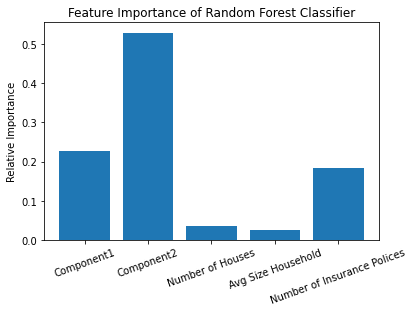

In [53]:
features = rf.feature_names_in_
features[0] = 'Component1'
features[1] = 'Component2'
features[2] = "Number of Houses"
features[3] = 'Avg Size Household'
features[4] = 'Number of Insurance Polices'
plt.bar(features, height=rf.feature_importances_)
plt.title("Feature Importance of Random Forest Classifier")
plt.ylabel("Relative Importance")
plt.xticks(rotation=20)